In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import preprocessing
import keras
import joblib
import tensorflow as tf
import numpy as np
import cv2
from keras.utils.np_utils import to_categorical

from sklearn.manifold import TSNE
from datetime import datetime
from matplotlib import pyplot as plt
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, Dropout, Activation, Flatten, MaxPooling2D

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np


Using TensorFlow backend.


In [2]:
assets = pd.read_excel("baksa_assents.xlsx")
census = pd.read_excel("baksa_census.xlsx")

In [3]:
assets = assets.fillna(0)
census = census.fillna(0)

In [4]:
assets.head(1)

,1,2,3,4,5,6,7,8,9,10,...,136,137,138,139,140,141,142,143,144,145
0,18,ASSAM,324,Baksa,0,Baksa,0,0,District - Baksa,Total,...,6.3,1.3,0.7,15.9,9.6,69.5,20.8,0.4,20.4,0.1


In [5]:
assets = assets[assets[10]=="Rural"].drop_duplicates(subset=9, keep="last")

In [6]:
assets_X = assets.loc[:, 9:].drop(columns={10}) #, 85, 86

In [7]:
assets_X.rename(columns={9:'Name'}, inplace=True)

In [8]:
electricity = assets.loc[:, 85:86].values

In [9]:
census.head(1)

,State,District,Subdistt,Town/Village,Ward,EB,Level,Name,TRU,No_HH,...,MARG_AL_0_3_F,MARG_HH_0_3_P,MARG_HH_0_3_M,MARG_HH_0_3_F,MARG_OT_0_3_P,MARG_OT_0_3_M,MARG_OT_0_3_F,NON_WORK_P,NON_WORK_M,NON_WORK_F
0,18,324,0,0,0,0,DISTRICT,Baksa,Total,191701,...,4571,2208,465,1743,6093,3049,3044,543319,214719,328600


In [10]:
census = census[census['TRU']=="Rural"].drop_duplicates(subset='Name', keep="last")

In [11]:
census_X = census.loc[:, 'Name':].drop(columns={'TRU'})

In [12]:
combined_names = pd.merge(assets_X, census_X, on=['Name'])['Name'].tolist()

In [13]:
images_X = []
for i in range(0, 652):
    n = cv2.resize(cv2.imread('data_assam/image_'+str(i)+".jpg"), (100, 100))
    images_X.append(n)
images_X = np.array(images_X) #.reshape(len(images), -1)

In [29]:
X_a = []
X_b = []
X_image = []
y = []

for idx, i in enumerate(combined_names):
    X_a.append(census_X[census_X['Name']==i].values[0][1:].tolist())
    X_b.append(assets_X[assets_X['Name']==i].values[0][1:].tolist())
    X_image.append(images_X[idx])
    y.append(electricity[idx])

X_a = preprocessing.scale(np.array(X_a))
X_b = preprocessing.scale(np.array(X_b))
X_image = np.array(X_image)/255
y = np.array(y)
y = np.argmax(preprocessing.scale(y), axis=1)
y_ = to_categorical(y)

In [30]:
X_a.shape, X_b.shape, X_image.shape, y.shape

((639, 85), (639, 135), (639, 100, 100, 3), (639,))

In [31]:
X_a_train, X_a_test, X_b_train, X_b_test, X_image_train, X_image_test, y_train, y_test = train_test_split(X_a, 
                                                                                         X_b, X_image, y_, test_size=0.2)

In [17]:
X_a_train.shape, X_a_test.shape

((511, 85), (128, 85))

In [18]:
image_input = Input(shape=(100, 100, 3), name='image_input')

shared = Conv2D(512, (3, 3), padding='same', activation='relu')(image_input)
shared = MaxPooling2D((2, 2), padding='same')(shared)
shared = Conv2D(128, (3, 3), padding='same', activation='relu')(shared)
shared = MaxPooling2D((2, 2), padding='same')(shared)
shared = Dropout(0.25)(shared)
shared = Conv2D(32, (3, 3), padding='same', activation='relu')(shared)
shared = MaxPooling2D((2, 2), padding='same')(shared)
shared = Dropout(0.25)(shared)
shared = Conv2D(8, (3, 3), padding='same', activation='relu')(shared)
shared = MaxPooling2D((2, 2), padding='same')(shared)
shared = Dropout(0.25)(shared)
shared = Flatten()(shared)

inputA_ = Input(shape=(85,))
inputA = Dense(4096, activation="relu")(inputA_)
inputA = Dense(2048, activation="relu")(inputA)
inputA = Dense(2048, activation="relu")(inputA)
inputA = Dense(1024, activation="relu")(inputA)

inputB_ = Input(shape=(135,))
inputB = Dense(4096, activation="relu")(inputB_)
inputB = Dense(2048, activation="relu")(inputB)
inputB = Dense(2048, activation="relu")(inputB)
inputB = Dense(1024, activation="relu")(inputB)
 
combined = Concatenate()([inputA, inputB, shared])
 
z = Dense(4096, activation="relu")(combined)
z = Dense(2048, activation="relu")(z)
z = Dense(512, activation="relu")(z)
z = Dense(64, activation="relu")(z)
z = Dense(2, activation="softmax")(z)
 
model = Model(inputs=[inputA_, inputB_, image_input], outputs=z)

In [19]:
# model.summary()

In [20]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit([X_a_train, X_b_train, X_image_train], [y_train], epochs=50, validation_data=([X_a_test, X_b_test, X_image_test], y_test))

Train on 511 samples, validate on 128 samples
Epoch 1/50
511/511 [==============================] - 40s 78ms/sample - loss: 9.8272 - accuracy: 0.5088 - val_loss: 0.6896 - val_accuracy: 0.5781
Epoch 2/50
511/511 [==============================] - 27s 53ms/sample - loss: 0.7123 - accuracy: 0.5675 - val_loss: 0.6950 - val_accuracy: 0.4531
Epoch 3/50
511/511 [==============================] - 26s 52ms/sample - loss: 0.7598 - accuracy: 0.5342 - val_loss: 0.6894 - val_accuracy: 0.5781
Epoch 4/50
511/511 [==============================] - 27s 52ms/sample - loss: 0.7215 - accuracy: 0.5342 - val_loss: 1.3318 - val_accuracy: 0.5781
Epoch 5/50
448/511 [=========================>....] - ETA: 3s - loss: 0.7240 - accuracy: 0.5793

KeyboardInterrupt: 

In [24]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [32]:
def plot_tsne(X, y):
    tsne = TSNE(n_components=2, random_state=0)
    k = tsne.fit_transform(X)
    scatter = plt.scatter(k[:, 0], k[:, 1], c=y)
    plt.legend(*scatter.legend_elements(num=np.unique(y)), loc="upper right", title="Classes")
    plt.show()

/home/william18026/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


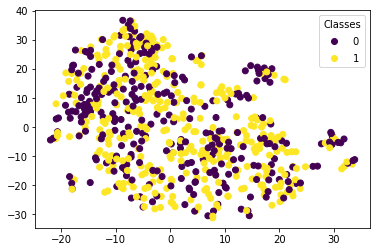

In [52]:
plot_tsne(pca.fit_transform(X_a), y)

/home/william18026/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/collections.py:974: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


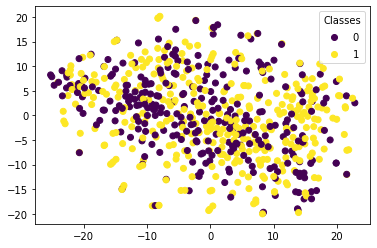

In [53]:
plot_tsne(pca.fit_transform(X_b), y)

In [39]:
from sklearn.decomposition import PCA

In [50]:
pca = PCA(n_components=0.99)

In [51]:
pca.fit_transform(X_a).shape

(639, 25)

In [44]:
X_a.shape

(639, 85)

## Appendix

In [ ]:
# assets.loc[:, :9].drop(columns={1,3,5,7,8}).to_pickle("images")